In [1]:
# Básicos
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tqdm
from joblib import dump, load

# Modelos
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict



# Avisos
import warnings
warnings.filterwarnings("ignore")

# 1. Carga datos:

### Rutas

In [2]:
ruta_datos_procesados = os.getcwd().replace("Modelos", "Datos\\Procesados\\")
ruta_modelo = os.getcwd()

### Datos empleos

In [3]:
df_empleos = pd.read_csv(ruta_datos_procesados + 'datos_jobs_finales.csv')
df_empleos_nuevos = pd.read_csv(ruta_datos_procesados + 'datos_jobs_finales_nuevos.csv')

In [32]:
df_empleos_nuevos["categoria_empleo"] = df_empleos_nuevos["categoria_empleo"].apply(lambda x: "machine learning engineer" if x == "machine learning" else x)

# 2. Prepocesamiento de datos

## 2.1. Funciones de procesamiento de datos:

In [4]:
def aplicar_mascara(df):
    
    df["comunidad"] = df["comunidad"].str.replace("Catalunya", "Cataluña").replace("Andalusia", "Andalucía").replace("Euskadi", "País Vasco")
    
    lista_comunidades = ["Región de Bruselas-Capital", "Distrito de Lisboa", "Jalisco", "State of Rio Grande do Sul", "Inglaterra", "Hanói", "Hồ Chí Minh", "Maryland", "Bogotá", "Baden-Wurtemberg", "Baja Sajonia", "Renania del Norte-Westfalia"]
    comunidades_mask = df["comunidad"].isin(lista_comunidades)
    df= df[~comunidades_mask]
    
    mask = (df["jornada"] == "no especificado") | (df["tipo_contrato"] == "no especificado") | (df["herramientas"] == "set()")
    df_filtrado = df[~mask].dropna()
    df_filtrado = df_filtrado.reset_index(drop= True)
    
    return df_filtrado

In [5]:
def agrupador_categorias(df):
    
    # Tipo de contrato
    tipos_contrato = ["indefinido", "temporal", "practicas"]
    df["tipo_contrato"] = df["tipo_contrato"].apply(lambda x: "otros contratos" if x not in tipos_contrato else x)
    
    # Jornada
    jornadas = ["jornada completa", "practicas", "media jornada"]    
    df["jornada"] = df["jornada"].apply(lambda x: "otras jornadas" if x not in jornadas else x)
    
    return df

In [6]:
def funcion_encoder(df, encoder):
    
    encoded_columns = ["jornada", "tipo_contrato", "comunidad", "categoria_empleo"]
    for columna in encoded_columns:
        
        data_encoded = encoder.fit_transform(df[[columna]]).toarray()
            
        with open(f"{columna}_encoder.pickle", 'wb') as archivo:
            pickle.dump(encoder, archivo)
            
        df_encoded = pd.DataFrame(data_encoded, columns= encoder.categories_)
        df = pd.concat([df, df_encoded], axis=1).drop([columna], axis=1)
        
    return df

In [7]:
def metodo_tukey(df, columna, alfa):
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    riq = q3 - q1

    df_sin_out = df[df[columna].between(q1 - alfa * riq, q3 + alfa * riq) | (df[columna].isna())]
    
    return df_sin_out

In [8]:
def data_preparation(df, top = False, log_transf= False):
    
    ########################### Selecciono valores no nulos ################################
    
    df_mod = df.drop(['titulo', 'empresa', 'fecha', 'descripcion','presencialidad', 'solicitudes', 'portal', 'localidad', 'provincia', 'pais', 'latitud', 'longitud'], axis= 1)
    df_mod = aplicar_mascara(df_mod)
    
    ########################### Agrupo categoricas ##########################################
    
    df_mod = agrupador_categorias(df_mod)
    
    ########################### Encoding columnas categoricas ###############################
    
    encoder = OneHotEncoder()
    df_mod = funcion_encoder(df_mod, encoder)
    
    ########################### Encoding de herramientas ####################################
    df_mod['herramientas'] = df_mod['herramientas'].apply(lambda x: re.sub(r"[{}']", '', x).split(', '))
    
    tool_encoder = MultiLabelBinarizer()
    encoded_tools = tool_encoder.fit_transform(df_mod['herramientas'])
    
    with open("tool_encoder.pickle", 'wb') as archivo:
        pickle.dump(tool_encoder, archivo)

    df_encoded = pd.DataFrame(encoded_tools, columns= tool_encoder.classes_)    
    df_mod = pd.concat([df_mod, df_encoded], axis=1).drop(['herramientas'], axis=1)
    
    ########################### Selecciono las top 20 herramientas ###########################
    if top:
        herramientas_top = df_mod[tool_encoder.classes_].sum().sort_values(ascending=False)
        columnas_top = herramientas_top[herramientas_top > 20]
        herramientas_no_necesarias = [herramienta for herramienta in tool_encoder.classes_ if herramienta not in columnas_top.index]
        df_mod = df_mod.drop(herramientas_no_necesarias, axis= 1)
    
    ########################### Elimino outliers del salario maximo y minimo ##################
    
    df_mod = metodo_tukey(df_mod, "salario_min", 1.5)
    df_mod = metodo_tukey(df_mod, "salario_max", 1.5)
    
    ########################### Transformación logarítmica salario maximo y minimo ############
    
    if log_transf:
        df_mod["salario_min"] = df_mod["salario_min"].apply(np.log)
        df_mod["salario_max"] = df_mod["salario_max"].apply(np.log)
    
    ########################### Limpio nombre columnas ########################################
    
    df_mod.columns = [str(columna).replace("('", "").replace("',)", "") for columna in df_mod.columns]
    
    ########################### Separo dataframes #############################################
    
    # Salario mínimo    
    df_salario_min = df_mod.drop(["salario_max"], axis= 1)
    # Salario máximo
    df_salario_max = df_mod.drop(["salario_min"], axis= 1)
    
    return df_salario_min, df_salario_max

## 2.2. Selección de dataframes para predicción

In [73]:
df_salario_min, df_salario_max = data_preparation(df_empleos_nuevos, top = False, log_transf= True)

## -----------------------------------------------------------------------------------------------------------------------------

## Herramientas top

In [32]:
herramientas_top = df_salario_max[tool_encoder_max.classes_].sum().sort_values(ascending=False)
columnas_top = herramientas_top[herramientas_top > 20]

herramientas_no_necesarias = [herramienta for herramienta in tool_encoder_max.classes_ if herramienta not in columnas_top.index]
df_salario_max = df_salario_max.drop(herramientas_no_necesarias, axis= 1)

## -----------------------------------------------------------------------------------------------------------------------------

# 3. Modelos de regresión

In [29]:
# Preprocess:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Modelos:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Modelos para matrices sparse
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR

# Red neuronal
from tensorflow.keras.optimizers import Adam

# Metricas para regresiones:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## 3.1. Preparación de datos

- ### Salario mínimo

In [74]:
X_min = df_salario_min.drop(["salario_min"], axis= 1)
y_min = df_salario_min[["salario_min"]]

- ### Salario máximo

In [75]:
X_max = df_salario_max.drop(["salario_max"], axis= 1)
y_max = df_salario_max[["salario_max"]]

## 3.2. Testeo de modelos

In [26]:
def model_tester(modelos, X, y):
    
    model_cross_holdout = []
    
    for modelo in modelos:

        r2_score_results, mean_squared_error_results, mean_absolute_error_results = [], [], []

        for i in range(20):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)

            r2_score_results.append(r2_score(y_test, y_pred))
            mean_squared_error_results.append(mean_squared_error(y_test, y_pred))
            mean_absolute_error_results.append(mean_absolute_error(y_test, y_pred))
            

        model_cross_holdout.append([str(modelo).split("(")[0],
                                    np.array(r2_score_results).mean(),
                                    np.array(mean_squared_error_results).mean(),
                                    np.array(mean_absolute_error_results).mean()
                                   ])
        
    

    df_cross_holdout = pd.DataFrame(model_cross_holdout, columns= ["nombre", "mean_r2", "mean_MSE", "mean_MAE"])
    #df_cross_holdout.to_csv("cross_holdout_results.csv", index= False, sep= ",")
    
    return df_cross_holdout

In [30]:
modelos = [LinearRegression(), RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(), Ridge(), Lasso(), ElasticNet(), XGBRegressor(), LinearSVR()]

- ### Salario mínimo

In [76]:
MIN_SIN_PCA = model_tester(modelos, X_min, y_min)

In [77]:
MIN_SIN_PCA[MIN_SIN_PCA["mean_r2"] > 0.3].sort_values(by= "mean_r2", ascending= False)

,nombre,mean_r2,mean_MSE,mean_MAE
0,SVR,0.455291,0.048527,0.165536


- ### Salario máximo

In [78]:
MAX_SIN_PCA = model_tester(modelos, X_max, y_max)

In [79]:
MAX_SIN_PCA[MAX_SIN_PCA["mean_r2"] > 0.3].sort_values(by= "mean_r2", ascending= False)

,nombre,mean_r2,mean_MSE,mean_MAE
0,SVR,0.475734,0.050949,0.173339


### 3.2.1. TUNING SVR

In [60]:
def tunning(modelo, parametros, X_train, X_test, y_train, y_test, salario):
    
    resultados = []
    
    grid_search = GridSearchCV(estimator  = modelo,
                               param_grid = parametros,
                               scoring    = "neg_mean_squared_error",
                               cv         = 5,
                               refit      = True,
                               n_jobs     = -1,  # Use all available processors
                               verbose    = 2)

    model_result = grid_search.fit(X_train, y_train)

    # Mejor modelo:
    best_model = model_result.best_estimator_
    params_best_model = best_model.get_params()

    y_pred = best_model.predict(X_test)

    # Metricas:
    r2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)

    resultados.append([str(modelo).split("(")[0], best_model, params_best_model, r2, MAE, MSE])
    df_resultados = pd.DataFrame(resultados, columns= ["Nombre", "Modelo", "Parametros","r2_score", "MAE", "MSE"])
    df_resultados.to_csv(f"salario_{salario}_tuning_svr.csv", index= "False", sep= ",")
    dump(best_model, f'salario_{salario}_svr.pkl')
    
    return df_resultados

In [53]:
modelo_SVR = SVR()

params_SVR = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [3, 4],
              'gamma': ['scale', 'auto'],
              'coef0': [-0.5, -0.4, -0.6],
              'C': [0.2, 0.3, 0.4],
              'epsilon': [0.01],
              'shrinking': [True],
              'tol': [1e-6, 1e-7],
              'cache_size': [100, 200],
              'verbose': [False],
              'max_iter': [550, 600, 700],
             }

In [55]:
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_min, y_min, test_size = 0.2, random_state=42)
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max, y_max, test_size = 0.2, random_state=42)

resultados = []

for modelo, params in zip(modelos,parametros):
    resultado = tunning(modelo, params, X_train_max, X_test_max, y_train_max, y_test_max)
    resultados.append(resultado)
    
resultados = [resultado[0] for resultado in resultados]
df_resultados = pd.DataFrame(resultados, columns= ["Nombre", "Modelo", "Parametros","r2_score", "MAE", "MSE"])

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


In [58]:
df_resultados["Parametros"].values

array([{'C': 0.2, 'cache_size': 100, 'coef0': -0.5, 'degree': 3, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 500, 'shrinking': True, 'tol': 1e-06, 'verbose': False}],
      dtype=object)

### 3.2.2. Best SVR models

In [59]:
modelo_SVR = SVR()
params_SVR_min = {'kernel': ['rbf'],
                  'degree': [3],
                  'gamma': ['scale'],
                  'coef0': [-0.5],
                  'C': [0.2],
                  'epsilon': [0.01],
                  'shrinking': [True],
                  'tol': [1e-6],
                  'cache_size': [100],
                  'verbose': [False],
                  'max_iter': [600],
                 }
    
params_SVR_max = {'kernel': ['rbf'],
                  'degree': [3],
                  'gamma': ['scale'],
                  'coef0': [-0.5],
                  'C': [0.2],
                  'epsilon': [0.01],
                  'shrinking': [True],
                  'tol': [1e-6],
                  'cache_size': [100],
                  'verbose': [False],
                  'max_iter': [500],
                 }

X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_min, y_min, test_size = 0.2, random_state=42)
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max, y_max, test_size = 0.2, random_state=42)

In [61]:
df_resultados_tuning_min = tunning(modelo_SVR, params_SVR_min, X_train_min, X_test_min, y_train_min, y_test_min, "min")
df_resultados_tuning_max = tunning(modelo_SVR, params_SVR_max, X_train_max, X_test_max, y_train_max, y_test_max, "max")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [62]:
df_resultados_tuning_min

,Nombre,Modelo,Parametros,r2_score,MAE,MSE
0,SVR,"SVR(C=0.2, cache_size=100, coef0=-0.5, epsilon...","{'C': 0.2, 'cache_size': 100, 'coef0': -0.5, '...",0.450102,0.172478,0.050469


In [63]:
df_resultados_tuning_max

,Nombre,Modelo,Parametros,r2_score,MAE,MSE
0,SVR,"SVR(C=0.2, cache_size=100, coef0=-0.5, epsilon...","{'C': 0.2, 'cache_size': 100, 'coef0': -0.5, '...",0.500629,0.1779,0.051512


## 3.3. PCA

Abrir los mejores modelos guardados y probar con PCA

In [119]:
def pca_tester(salarios, modelos_svr, X_sal, y_sal):
    resultados_PCA = []

    for salario, modelo_svr, X, y in zip(salarios, modelos_svr, X_sal, y_sal):

        resultados = []
        for componentes in range(2, X.shape[1]):

            pca = PCA(componentes, random_state=42)
            X_pca = pca.fit_transform(X)
            X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state=42)

            modelo_svr.fit(X_train, y_train)
            y_pred = modelo_svr.predict(X_test)

            # Métricas:
            r2 = r2_score(y_test, y_pred)
            MAE = mean_absolute_error(y_test, y_pred)
            MSE = mean_squared_error(y_test, y_pred)

            if r2 > 0.46:
                resultados.append([salario, componentes, r2, MAE, MSE])

        resultados_PCA.extend(resultados)

    df_resultados_PCA = pd.DataFrame(resultados_PCA, columns= ["salario", "componentes", "R2", "MAE", "MSE"])
    return df_resultados_PCA

In [120]:
modelo_svr_min = load('salario_min_svr.pkl')
modelo_svr_max = load('salario_max_svr.pkl')

In [121]:
salarios = ["min", "max"]
modelos_svr = [modelo_svr_min, modelo_svr_max]
X = [X_min, X_max]
y = [y_min, y_max]

In [122]:
df_resultados_PCA = pca_tester(salarios, modelos_svr, X, y)

In [131]:
df_resultados_PCA[df_resultados_PCA["salario"] == "min"].sort_values(by= "R2", ascending= False).head(1)

,salario,componentes,R2,MAE,MSE
33,min,136,0.464965,0.167694,0.049105


In [132]:
df_resultados_PCA[df_resultados_PCA["salario"] == "max"].sort_values(by= "R2", ascending= False).head(1)

,salario,componentes,R2,MAE,MSE
176,max,130,0.517913,0.171782,0.049729


# 4. Redes Neuronales

In [472]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, Dense, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.callbacks import ReduceLROnPlateau

In [307]:
# Escalado:
scaler = StandardScaler()
X_min_scaled = scaler.fit_transform(X_min)

In [642]:
X_min = X_min.values.astype(int)

In [643]:
X_train, X_test, y_train, y_test = train_test_split(X_min, y_min, test_size = 0.2, random_state=42)

In [644]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [645]:
# Model definition
np.random.seed(42)
model = Sequential()

model.add(Dense(units = 200, input_shape= (X_train.shape[1],), activation="linear"))  # Adjust input shape
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(units = 128))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(units = 64))
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Hidden layers (optional, experiment with number and neurons)
##model.add(Dense(128, activation="relu"))
#model.add(Dense(64, activation="relu"))
#model.add(Dense(32, activation="relu"))

model.add(Dense(1, activation="linear"))  # Output layer for regression

# Model compilation
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))  # Adjust loss and optimizer as needed

#model.summary()

In [646]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience= 5)

# Model training
history = model.fit(X_train,
                    y_train.values,
                    validation_data=(X_val, y_val.values),
                    epochs= 100,
                    #batch_size= 100,
                    callbacks=[early_stopping],
                    verbose = 1
)

# Model evaluation on test set
model.evaluate(X_test, y_test.values)

Epoch 1/100
22/22 [==============================] - 1s 9ms/step - loss: 61.4733 - val_loss: 5.3962
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 10.5281 - val_loss: 6.5306
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 5.5870 - val_loss: 2.1335
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 4.2049 - val_loss: 1.4136
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 3.2637 - val_loss: 1.0693
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 2.7416 - val_loss: 0.6402
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 2.4298 - val_loss: 0.7467
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 2.3262 - val_loss: 0.3773
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 2.2521 - val_loss: 0.3101
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 2.0882 - val_loss: 0.3828
Epoch 1

0.34529343247413635

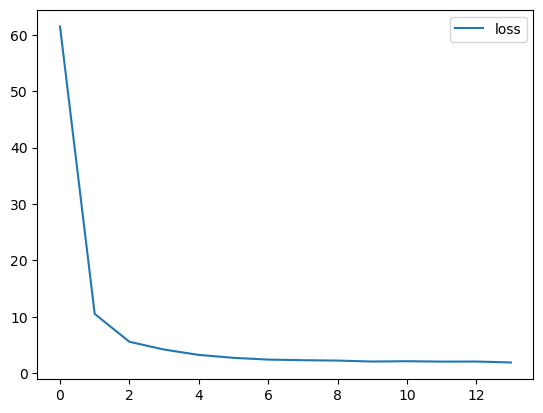

In [647]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.legend()
plt.show()

In [648]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 1ms/step


In [649]:
r2_score_results = r2_score(y_test, y_pred)
mean_squared_error_results = mean_squared_error(y_test, y_pred)
mean_absolute_error_results = mean_absolute_error(y_test, y_pred)

In [650]:
print(r2_score_results)
print(mean_squared_error_results)
print(mean_absolute_error_results)

-2.762215262873278
0.34529359046991415
0.4713082304183239


In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential


In [52]:
X = df_salario_max.drop(["salario_max"], axis= 1)
y = df_salario_max[["salario_max"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [53]:
def create_regression_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1) 
    ])

    model.compile(optimizer= "adam", loss='mean_squared_error')
    
    return model

imput_shape = X.shape[1]

regression_model = create_regression_model(imput_shape)

regression_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                5568      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9793 (38.25 KB)
Trainable params: 9793 (38.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = regression_model.fit(X_train.values.astype(int), y_train.values, epochs= 100)

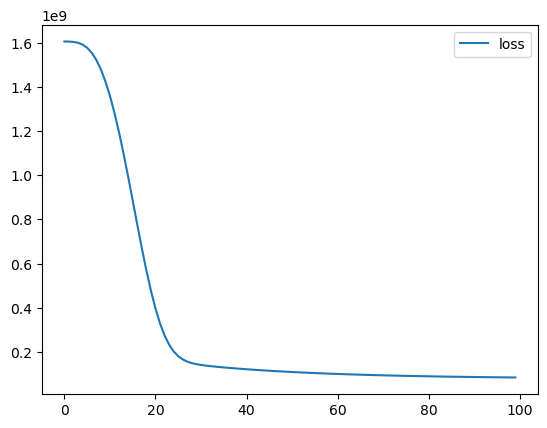

In [55]:
# loss
plt.plot(history.history["loss"], label = "loss")
plt.legend()
plt.show()

In [56]:
y_pred = regression_model.predict(X_test.values.astype(int))

7/7 [==============================] - 0s 1ms/step


In [58]:
r2_score_results = r2_score(y_test, y_pred)
mean_squared_error_results = mean_squared_error(y_test, y_pred)
mean_absolute_error_results = mean_absolute_error(y_test, y_pred)

In [59]:
print(r2_score_results)
print(mean_squared_error_results)
print(mean_absolute_error_results)

0.40049333194970516
94005198.67956196
7431.486504878394


In [38]:
# Para graficar:

modelo_gbr = GradientBoostingRegressor()
df_salario_max.columns = df_salario_max.columns.astype(str)
modelo_gbr.fit(X_train, y_train)
y_pred = modelo_gbr.predict(X_test)

In [39]:
test_y = y_test["salario_max"].values.flatten()

In [40]:
pred_y = y_pred.flatten()

<Axes: >

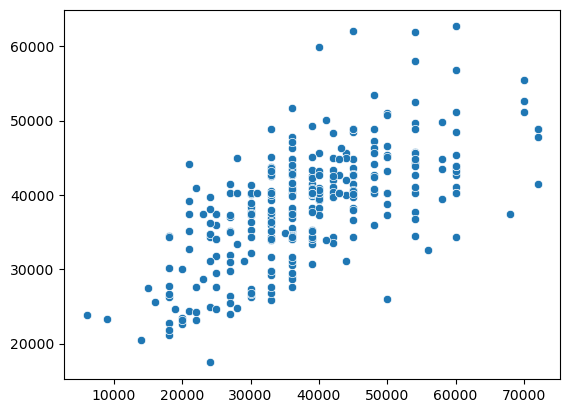

In [41]:
sns.scatterplot(x= test_y, y= pred_y)